<p align = "center">
<img src = '../docs/logo.png' height = "250">
</p>

<h1 align = 'center'>Trabalho de Conversão Eletromecânica<h1/>
<h2 align = 'center'>Exercício 3<h2/>

Este exercício tem como objetivo o estudo referente ao comportamento de um circuito magnético excitado por um imã. 

Alunos:

- André Vitor Cadena de Oliveira
- Fábio Augusto Almeida Marçal
- Gabriel Nazário Gonçalves
- Lorenzo Carrera de Oliveira
- Mateus Pincho de Oliveira

---

Considere o circuito magnético a seguir e responda os itens: 

<p align = "center">
<img src = '../docs/circuito_ima.png' height = "250">
</p>

Além disso, considere que o imã pode ser caracterizado pela curva: 

<p align = "center">
<img src = '../docs/curva_ima.png' height = "300">
</p>

Observe que são fornecidas duas curvas, que apesar de muito semelhantes, a diferença entre essas curvas é utilizada para a realização de projetos de alta precisão em circunstâncias de variação de temperatura e incidência de campo externo. 

**Para este exercício, considere apenas a curva normal.**

---

In [1]:
# Importando módulos...
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.misc import derivative
from scipy.interpolate import CubicSpline # Interpolação spline

# Lidando com os warnings dos plots
import warnings
warnings.filterwarnings('ignore')

## Importando dados da questão
---

In [2]:
W_m = 2e-2
W_g = 2.5e-2
D = 3e-2
d = 1e-2
g = 0.2e-2
A_m = W_m * D

# B e H de acordo com o material; esses dados são expeirmentalmente (definidos pelo fabricante)
H_m_amostra = 1000 * np.array([-51,-50, -49.5,-49, -48, -47.5, -47, -46.5, -45.5, -44, -37, -31, -26, 0])
B_m_amostra = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5 , 0.6, 0.7, 0.8, 0.9, 1.0, 1.05, 1.1, 1.2])

# Ponto de operação
H_op = -32e3
B_op = 1.07

# Valores de Br (Magnetização Remanescente) e Hc (Coercitividade)
H_c = H_m_amostra[0]
B_r = B_m_amostra[-1]

u_0 = 4 * np.pi * 1e-7 # Permissividade magnética do ar
u_r = B_r/(-H_c) # Permissividade magnética relativa

H__B_real = CubicSpline(B_m_amostra, H_m_amostra, bc_type='natural')

n_amostras = 100 # Quantidade de pontos a serem interpolados
B_m = np.linspace(0, np.max(B_m_amostra), n_amostras) # Pontos de B igualmente espaçados 
def H__B_linear(B): return (B / u_r) + H_c # Aproximação linear

## Item 01
Apresente um gráfico para a força magnética que surge no elemento móvel nas condições a seguir:

- Uma aproximação linear na forma $B_m = \mu_R(H_m - H_c)$ ;
- Curva $B\times H$ fornecida para o imã.

---

In [3]:
# Calcula a força do bloco em função da posição x
def F__x(aprox_H__B, range_x, N, I_op):
    lamb = N * A_m * B_m # Transformação de densidade de fluxo para fluxo concatenado

    # Intervalo de variação de x (remove o último elemento para evitar singularidade)
    intervalo_x = np.linspace(range_x[0], range_x[1], n_amostras+1)[:-1] 

    # Vetor vazio da coenergia
    W_c = []

    # Repetição para cada posição x
    for x in intervalo_x:
        A_g = (W_g - x) * D

        # Corrente baseada na Lei de Ampère
        I_f = (aprox_H__B(B_m) * d + 2 * g * (B_m * A_m)/(u_0 * A_g))/N
        
        # Achando a corrente para fluxo concatenado 0
        I_f__B_m = CubicSpline(B_m, I_f, bc_type='natural')

        I_0 = I_f__B_m(0) # Fluxo concatenado 0

        intervalo_I = np.linspace(I_0, I_op, n_amostras)

        # Interpolação dos Fluxos Concatenados
        lamb__I = CubicSpline(I_f, lamb, bc_type='natural') # Curva λxI

        # Coenergia integrando o fluxo no intervalo de variação de I (I_0 à 0) para cada valor de x
        W_c.append(sp.integrate.trapezoid(lamb__I(intervalo_I), intervalo_I))

    W_c = np.array(W_c)

    # Curvas coenergia em função da variação de x
    W_c__x = CubicSpline(intervalo_x, W_c, bc_type='natural')

    # Determinando a força magnética pela derivada da coenergia em relação a x
    F = derivative(W_c__x, intervalo_x, dx=np.max(intervalo_x)/n_amostras)

    # Função de Força x Posição
    F__x = CubicSpline(intervalo_x, F, bc_type='natural')

    return F__x, intervalo_x

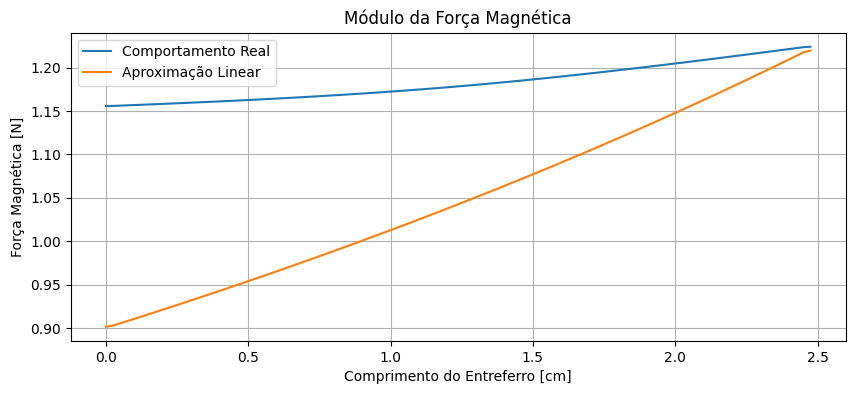

In [4]:
# Gráficos da força
plt.figure(figsize=(10,4))
plt.title(f'Módulo da Força Magnética')
plt.xlabel('Comprimento do Entreferro [cm]')
plt.ylabel('Força Magnética [N]')

for aprox_H__B, tipo in [[H__B_real, 'Comportamento Real'],
                         [H__B_linear, 'Aproximação Linear']]:
        
    aprox_F__x, intervalo_x = F__x(aprox_H__B, [0, W_g], 1, 0) # Calculando a curva de força por posição
    plt.plot(intervalo_x * 1e2, np.abs(aprox_F__x(intervalo_x)), label=tipo) # Plotando a curva
    
plt.grid(True)
plt.legend(loc='best')

## Item 02

Considerando que é acrescentado uma bobina de 1500 espiras ao sistema: 

- Para um elemento móvel na posição $x = \frac{W_g}{2}$, apresente um gráfico da Densidade de Fluxo $B$ no entreferro em função da corrente aplicada na bobina.

---

In [5]:
# Calcula a densidade de fluxo em função da corrente para uma posição x e N espiras
def B_g(aprox_H__B, x, N):
    A_g = (W_g - x) * D

    # Corrente baseada na Lei de Ampère
    I = (aprox_H__B(B_m) * d + 2 * g * (B_m * A_m)/(u_0 * A_g))/N

    # Densidade de fluxo no entreferro
    B_g = B_m * A_m / A_g

    # Interpolação dos Fluxos Concatenados
    B_g__I = CubicSpline(I, B_g, bc_type='natural') 

    return B_g__I, I

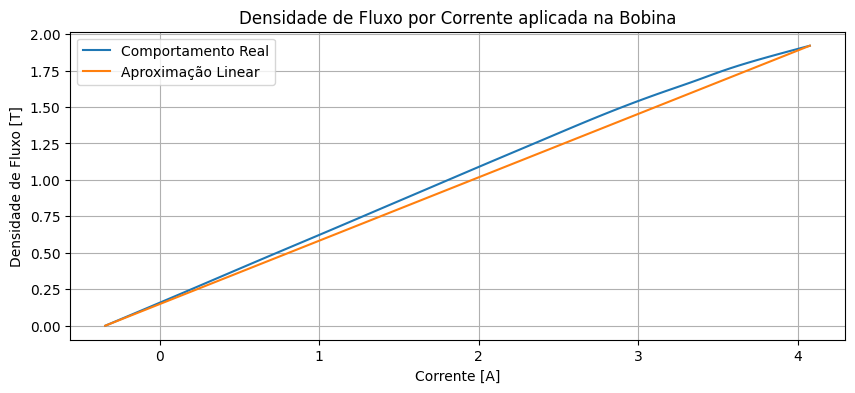

In [6]:
N = 1500

# Gráficos da força
plt.figure(figsize=(10,4))
plt.title(f'Densidade de Fluxo por Corrente aplicada na Bobina')
plt.xlabel('Corrente [A]')
plt.ylabel('Densidade de Fluxo [T]')

for aprox_H__B, tipo in [[H__B_real, 'Comportamento Real'],
                         [H__B_linear, 'Aproximação Linear']]:
        
    aprox_B_g__I, I = B_g(aprox_H__B, W_g/2, N) # Calculando a curva de densidade de fluxo por corrente
    plt.plot(I, aprox_B_g__I(I), label=tipo) # Plotando a curva
    
plt.grid(True)
plt.legend(loc='best')

## Item 03

Considere que é aplicada na bobina uma corrente constante tal que, para o corpo na posição $x = \frac{W_g}{2}$, o sistema esteja no ponto de operação normal indicado pelo fabricante do imã. 

Nessas condições, apresente um gráfico para a força magnética em função da posição $x$.

---

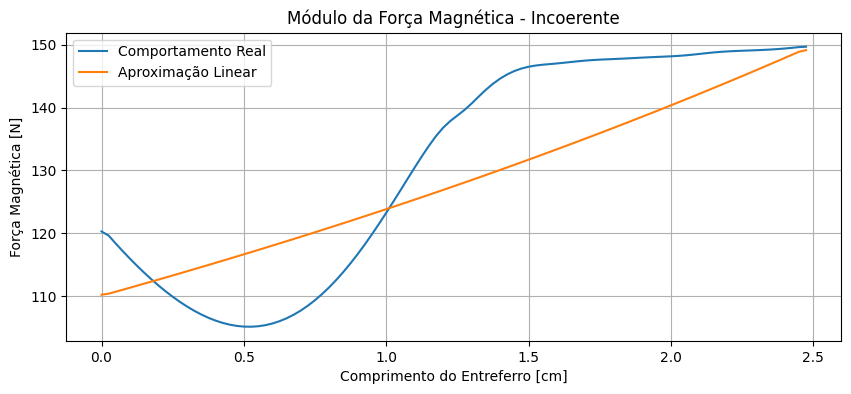

In [7]:
x_op = W_g/2 
I_op = (H_op * d + (2 * g * B_op * A_m)/((W_g - x_op) * D * u_0)) / N # Lei de Ampère
I_max = (np.max(H_m_amostra) * d + 2 * g * np.max(B_m_amostra)/u_0) / N # Lei de Ampère

# Gráficos da força
plt.figure(figsize=(10,4))
if I_op > I_max:
    plt.title(f'Módulo da Força Magnética - Incoerente')
else:
    plt.title(f'Módulo da Força Magnética')
plt.xlabel('Comprimento do Entreferro [cm]')
plt.ylabel('Força Magnética [N]')

for aprox_H__B, tipo in [[H__B_real, 'Comportamento Real'],
                         [H__B_linear, 'Aproximação Linear']]:
        
    aprox_F__x, intervalo_x = F__x(aprox_H__B, [0, W_g], N, I_op) # Calculando a curva de força por posição
    plt.plot(intervalo_x * 1e2, np.abs(aprox_F__x(intervalo_x)), label=tipo) # Plotando a curva
    
plt.grid(True)
plt.legend(loc='best')